In [1]:
import timeit
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import boto3
import awswrangler as wr

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler

from mpl_toolkits.mplot3d import Axes3D

In [2]:
boto3.setup_default_session(profile_name='datasci')

In [3]:
q = f"""
SELECT post_evar3, browser_type, OS as brows_os, page_event_var2, missing_prod_view, page_error, excluded_hit_error
    , visit_num, hit_time_gmt, page_load_time, sum(error_pv_factor + page_error_factor + page_load_time_factor + excluded_hit_error_factor) as error_factor
FROM (
SELECT case when post_evar3 is not null then post_evar3 else 'None' end as post_evar3
    , case when b_type.col1 is not null then b_type.col1 else 'None' end as browser_type
    , case when os.col1 is not null then os.col1 else 'None' end as OS
    , case when post_page_event_var2 is not null then post_page_event_var2 else 'None' end as page_event_var2
    , case when post_event_list not like '%,201,%' then 1 else 0 end as missing_prod_view
    , case when post_event_list like '%,203,%' then 1 else 0 end as page_error
    , case when exclude_hit = '0' then 0 else 1 end as excluded_hit_error
    , visit_num, visit_page_num, hit_time_gmt, try_cast(post_prop68 as bigint) as page_load_time
    
    , case when post_event_list like '%,201,%' then 0 else 10 end as error_pv_factor
    , case when exclude_hit = '0' then 0 else 10 end as excluded_hit_error_factor
    , case when post_event_list not like '%,203,%' then 0 else 1000 end as page_error_factor
    , case when try_cast(post_prop68 as bigint) > 15000 then 100 else 0 end as page_load_time_factor
FROM "us_clickstream_prod"."daily" 
left join "us_clickstream_prod"."browser_type" as b_type
    on try_cast(daily.browser as bigint) = b_type.col0
left join "us_clickstream_prod"."operating_systems" as os
    on try_cast(daily.os as bigint) = os.col0
where page_url like 'https://www.landsend.com/products/%'
    and post_prop68 is not null
    and try_cast(post_prop68 as bigint) < 30000
    and year = '2024'
    and month = '10' 
    and day = '1'
)
group by 1,2,3,4,5,6,7,8,9,10
"""

In [4]:
df = wr.athena.read_sql_query(
    q,
    database="us_clickstream_prod", 
    s3_output = "s3://lerawzone/users/acscies/athena/"
)

In [5]:
df.isnull().values.any()

False

In [6]:
df.head()

,post_evar3,browser_type,brows_os,page_event_var2,missing_prod_view,page_error,excluded_hit_error,visit_num,hit_time_gmt,page_load_time,error_factor
0,external campaign,Apple,iOS 16.3.1,None,0,0,0,1,1727827919,1282,0
1,external campaign,Apple,OS X 10.15.7,None,0,0,0,5,1727790027,1850,0
2,external campaign,Google,OS X 10.15.7,None,0,0,0,1,1727817228,1010,0
3,site navigation,Apple,iOS 16.3,None,0,0,0,1,1727799290,509,0
4,recommendations,Apple,OS X 10.15.7,None,0,0,0,8,1727761936,1729,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825008 entries, 0 to 825007
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   post_evar3          825008 non-null  string
 1   browser_type        825008 non-null  string
 2   brows_os            825008 non-null  string
 3   page_event_var2     825008 non-null  string
 4   missing_prod_view   825008 non-null  Int32 
 5   page_error          825008 non-null  Int32 
 6   excluded_hit_error  825008 non-null  Int32 
 7   visit_num           825008 non-null  Int32 
 8   hit_time_gmt        825008 non-null  Int64 
 9   page_load_time      825008 non-null  Int64 
 10  error_factor        825008 non-null  Int64 
dtypes: Int32(4), Int64(3), string(4)
memory usage: 62.2 MB


In [8]:
min_hit_time = df['hit_time_gmt'].min() 

In [9]:
#To insert some errors into the dataset and create simulation  
df_append = pd.DataFrame(columns=["post_evar3", "browser_type", "brows_os", "page_event_var2",
                                  "missing_prod_view", "page_error", "excluded_hit_error",
                                 "visit_num", "hit_time_gmt", "page_load_time", "error_factor"], dtype="int")
for i in range(10000):
    hit_time_gmt = (min_hit_time + i)
    df_values = ['external campaign', 'None', 'None', 'None', 1, 1, 1, 1, hit_time_gmt, 35000, 999] 
    df_append.loc[len(df_append.index)] = df_values

In [10]:
df = pd.concat([df, df_append])

In [11]:
df.reset_index(drop=True, inplace=True)
df.tail()

,post_evar3,browser_type,brows_os,page_event_var2,missing_prod_view,page_error,excluded_hit_error,visit_num,hit_time_gmt,page_load_time,error_factor
835003,external campaign,None,None,None,1,1,1,1,1727768795,35000,999
835004,external campaign,None,None,None,1,1,1,1,1727768796,35000,999
835005,external campaign,None,None,None,1,1,1,1,1727768797,35000,999
835006,external campaign,None,None,None,1,1,1,1,1727768798,35000,999
835007,external campaign,None,None,None,1,1,1,1,1727768799,35000,999


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835008 entries, 0 to 835007
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   post_evar3          835008 non-null  object
 1   browser_type        835008 non-null  object
 2   brows_os            835008 non-null  object
 3   page_event_var2     835008 non-null  object
 4   missing_prod_view   835008 non-null  Int64 
 5   page_error          835008 non-null  Int64 
 6   excluded_hit_error  835008 non-null  Int64 
 7   visit_num           835008 non-null  Int64 
 8   hit_time_gmt        835008 non-null  Int64 
 9   page_load_time      835008 non-null  Int64 
 10  error_factor        835008 non-null  Int64 
dtypes: Int64(7), object(4)
memory usage: 75.7+ MB


In [13]:
df['page_load_time'].describe()

count    835008.000000
mean       2015.405955
std        4010.277023
min           9.000000
25%         844.000000
50%        1248.000000
75%        1856.000000
max       35000.000000
Name: page_load_time, dtype: float64

In [14]:
df['hit_time_gmt'].describe()

count    8.350080e+05
mean     1.727809e+09
std      1.970409e+04
min      1.727759e+09
25%      1.727795e+09
50%      1.727810e+09
75%      1.727826e+09
max      1.727845e+09
Name: hit_time_gmt, dtype: float64

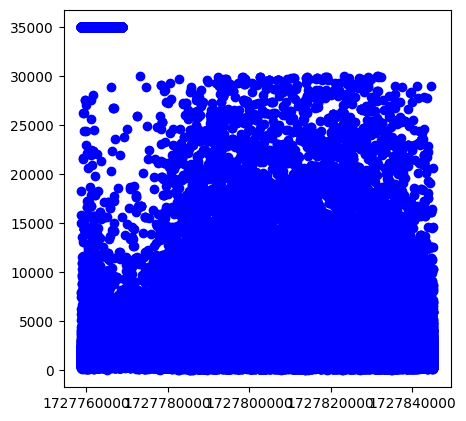

In [15]:
plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(df['hit_time_gmt'], df['page_load_time'], c ="blue")
plt.ticklabel_format(style='plain')
plt.ticklabel_format(useOffset=False)
plt.show()

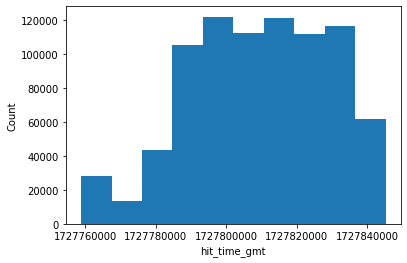

In [16]:
counts, bins = np.histogram(df['hit_time_gmt'])
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel('hit_time_gmt')
plt.ylabel('Count')
plt.ticklabel_format(style='plain')
plt.ticklabel_format(useOffset=False)
plt.show()

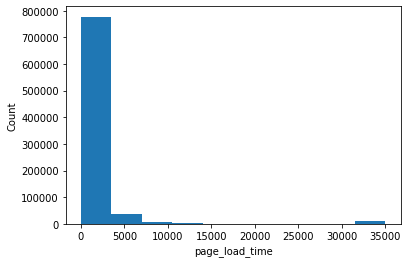

In [17]:
counts, bins = np.histogram(df['page_load_time'])
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel('page_load_time')
plt.ylabel('Count')
plt.show()

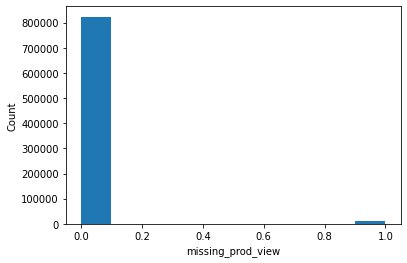

In [18]:
counts, bins = np.histogram(df['missing_prod_view'])
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel('missing_prod_view')
plt.ylabel('Count')
plt.show()

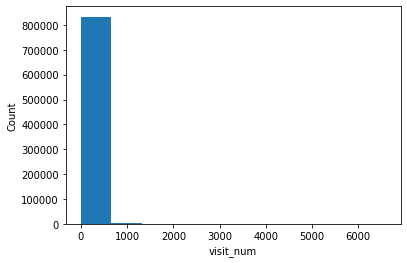

In [19]:
counts, bins = np.histogram(df['visit_num'])
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel('visit_num')
plt.ylabel('Count')
plt.show()

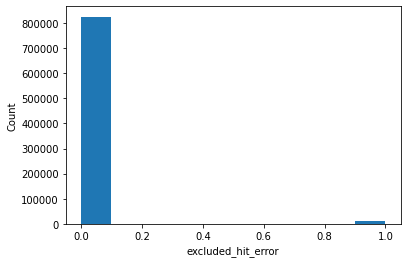

In [20]:
counts, bins = np.histogram(df['excluded_hit_error'])
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel('excluded_hit_error')
plt.ylabel('Count')
plt.show()

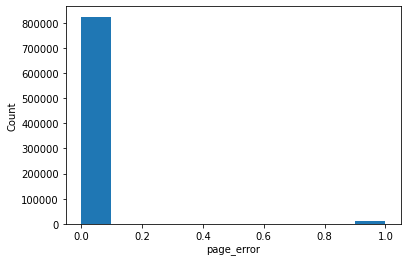

In [21]:
counts, bins = np.histogram(df['page_error'])
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel('page_error')
plt.ylabel('Count')
plt.show()

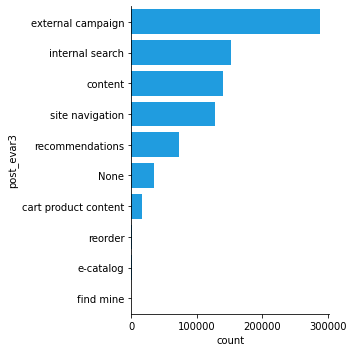

In [22]:
sns.catplot(y="post_evar3", kind="count", color='#00a5ff', data=df,
            order=df.post_evar3.value_counts().index)
plt.show()

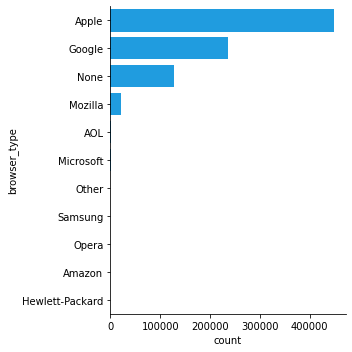

In [23]:
sns.catplot(y="browser_type", kind="count", color='#00a5ff', data=df,
            order=df.browser_type.value_counts().index)
plt.show()

In [24]:
df['browser_type'].value_counts()

Apple              449800
Google             235187
None               127602
Mozilla             21564
AOL                   714
Microsoft              83
Other                  18
Samsung                17
Opera                  12
Amazon                 10
Hewlett-Packard         1
Name: browser_type, dtype: int64

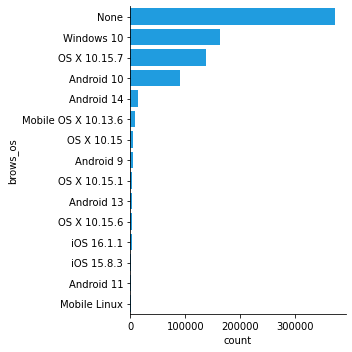

In [25]:
#Too many labels to print all and make sense. Only showing top 6. 
#is too many "None" to use with purspose.
sns.catplot(y="brows_os", kind="count", color='#00a5ff', data=df,
           order=df.brows_os.value_counts().iloc[:15].index)
plt.show()

In [26]:
df['brows_os'].value_counts()

None                   372367
Windows 10             163458
OS X 10.15.7           137501
Android 10              90722
Android 14              14355
                        ...  
iOS 15.7.4                  1
Android 7.1.2               1
iOS 12.5.1                  1
Mobile OS X 10.14.4         1
Mobile iOS 12.1.1           1
Name: brows_os, Length: 152, dtype: int64

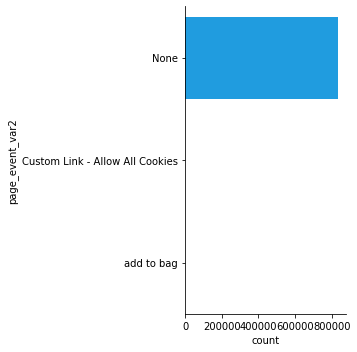

In [27]:
sns.catplot(y="page_event_var2", kind="count", color='#00a5ff', data=df,
            order=df.page_event_var2.value_counts().index)
plt.show()

In [28]:
df['page_event_var2'].value_counts()

None                               834479
Custom Link - Allow All Cookies       527
add to bag                              2
Name: page_event_var2, dtype: int64

In [29]:
#df[["post_evar3", "missing_prod_view", "page_error", "excluded_hit_error", "visit_num", "hit_time_gmt", "page_load_time", "error_factor"]]

In [30]:
#Example of a not helpful plot."Post_evar3" is not helpful to idendify high page load time anomolies.
#Sampled!
#sns.set(style="ticks", color_codes=True)
#pic = sns.pairplot(df[["post_evar3", "missing_prod_view", "page_error", "excluded_hit_error", "visit_num", "hit_time_gmt", "page_load_time", "error_factor"]].sample(n=5000), hue="post_evar3")
#pic = sns.pairplot(df[["post_evar3", "hit_time_gmt", "page_load_time", "error_factor"]].sample(n=5000), hue="post_evar3")
#pic.fig.set_size_inches(12,12)

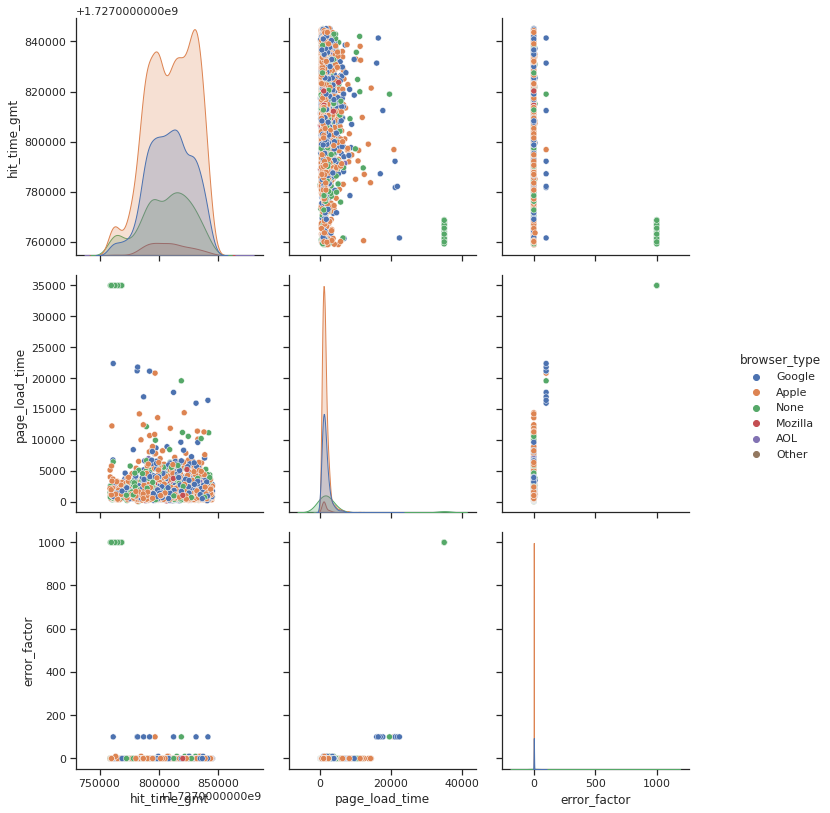

In [31]:
#Example of a helpful plot."browser_type" looks like it may be helpful to idendify high page load time anomolies. 
#Also, apple is very apparent.
#Sampled!
sns.set(style="ticks", color_codes=True)
pic = sns.pairplot(df[["browser_type", "hit_time_gmt", "page_load_time", "error_factor"]].sample(n=5000),
                   hue="browser_type")
pic.fig.set_size_inches(12,12)

In [32]:
#drop columns that won't help
df = df.drop(columns=['brows_os', 'post_evar3', 'page_event_var2'])
df.head()

,browser_type,missing_prod_view,page_error,excluded_hit_error,visit_num,hit_time_gmt,page_load_time,error_factor
0,Apple,0,0,0,1,1727827919,1282,0
1,Apple,0,0,0,5,1727790027,1850,0
2,Google,0,0,0,1,1727817228,1010,0
3,Apple,0,0,0,1,1727799290,509,0
4,Apple,0,0,0,8,1727761936,1729,0


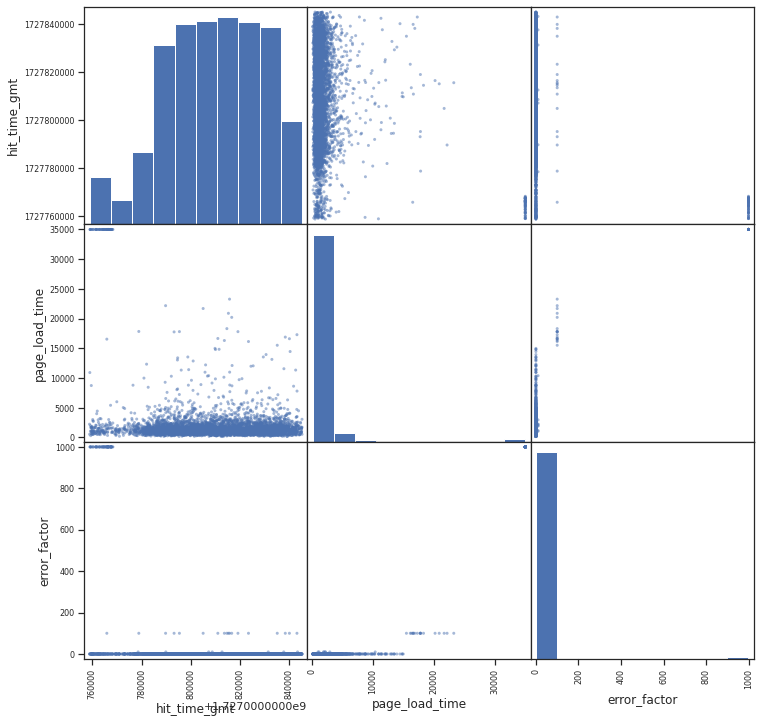

In [33]:
#Sampled!
scatter_matrix(df[["hit_time_gmt", "page_load_time", "error_factor"]].sample(n=5000),figsize=(12,12))
plt.ticklabel_format(style='plain')
plt.ticklabel_format(useOffset=False)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

<AxesSubplot:xlabel='error_factor', ylabel='browser_type'>

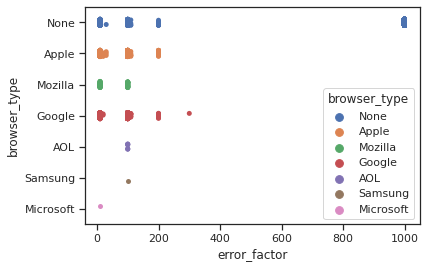

In [34]:
sns.stripplot(data=df[df["error_factor"] > 0] , x="error_factor", y="browser_type", hue="browser_type")

In [35]:
outlier_prct = df.query('error_factor > 0')['error_factor'].count() / df['error_factor'].count()
print("The outlier fraction is:")
outlier_prct

The outlier fraction is:


0.0172561220970338

In [36]:
#create testing DF 
forest_df = df[['browser_type', 'page_load_time', 'visit_num', 'hit_time_gmt',
                'page_error', 'excluded_hit_error', 'visit_num', 'error_factor']]#.sample(n=50000)
forest_df.head()

,browser_type,page_load_time,visit_num,hit_time_gmt,page_error,excluded_hit_error,visit_num,error_factor
0,Apple,1282,1,1727827919,0,0,1,0
1,Apple,1850,5,1727790027,0,0,5,0
2,Google,1010,1,1727817228,0,0,1,0
3,Apple,509,1,1727799290,0,0,1,0
4,Apple,1729,8,1727761936,0,0,8,0


In [37]:
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
standardizer = StandardScaler()

In [38]:
isoforest_stand = standardizer.fit_transform(forest_df.drop(columns=['browser_type','error_factor']))
type(isoforest_stand)

numpy.ndarray

In [39]:
print(isoforest_stand[0,])

[-0.18288173 -0.17643311  0.94679857 -0.11009584 -0.11009584 -0.17643311]


In [40]:
#%%timeit
clf=IsolationForest(n_estimators=300, max_samples='auto', contamination=outlier_prct, max_features=1.0)
clf.fit(isoforest_stand)
forest_df['anomaly'] = clf.predict(isoforest_stand)
forest_df['scores'] = clf.decision_function(isoforest_stand)

/tmp/ipykernel_30/1054582443.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forest_df['anomaly'] = clf.predict(isoforest_stand)
/tmp/ipykernel_30/1054582443.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forest_df['scores'] = clf.decision_function(isoforest_stand)


In [41]:
inlier, outlier = forest_df.loc[forest_df.anomaly==1], forest_df.loc[forest_df.anomaly==-1]
outlier.sort_values(['scores']).head(5)

,browser_type,page_load_time,visit_num,hit_time_gmt,page_error,excluded_hit_error,visit_num,error_factor,anomaly,scores
538508,None,27946,1198,1727814386,0,0,1198,100,-1,-0.081663
796876,None,27946,1198,1727814340,0,0,1198,100,-1,-0.081663
263532,None,27946,1198,1727814293,0,0,1198,100,-1,-0.081663
282339,None,27946,1198,1727814183,0,0,1198,100,-1,-0.081479
599340,None,27946,1198,1727814186,0,0,1198,100,-1,-0.081479


In [42]:
forest_df.anomaly.value_counts()

 1    820599
-1     14409
Name: anomaly, dtype: int64

In [43]:
#True positive outliers
forest_df.query('error_factor > 0 and anomaly == -1')['error_factor'].count()

10101

In [44]:
#False positive outliers
forest_df.query('error_factor == 0 and anomaly == -1')['error_factor'].count()

4308

In [45]:
#True positive inliers
forest_df.query('error_factor == 0 and anomaly == 1')['error_factor'].count()

816291

In [46]:
#False positive inliers
forest_df.query('error_factor > 0 and anomaly == 1')['error_factor'].count()

4308

In [47]:
#Very strong anomoly true positive and false negative outliers
print(forest_df.query('error_factor == 999 and anomaly == -1')['error_factor'].count())
print(forest_df.query('error_factor == 999 and anomaly == 1')['error_factor'].count())

10000
0


In [48]:
print("Start of OneClassSVM")

Start of OneClassSVM


In [49]:
#create testing DF 
#svm_df = df[['hit_time_gmt', 'page_load_time']].sample(n=400000)
svm_df = df[['hit_time_gmt', 'page_load_time']].sample(n=5000)
#svm_df.info()

In [50]:
scaler = StandardScaler()
X = scaler.fit_transform(svm_df)

In [51]:
X.size

10000

In [52]:
print(X[0,])

[-0.91073163 -0.4168958 ]


In [53]:
#Below makes a nice graph compairison but not useful for f-score data
'''
#%%timeit
estimators_hard_margin = {
   "Hard Margin OCSVM": OneClassSVM(kernel='rbf', nu=outlier_prct, gamma='auto'), 
}

#estimators_soft_margin = {
#   "Soft Margin OCSVM": OneClassSVM(kernel='rbf', nu=0.25, gamma='auto'), 
#}

# Plotting setup
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
colors = ["tab:blue", "tab:orange", "tab:red"]
legend_lines = []

# Hard Margin OCSVM
ax = axs[0]
for color, (name, estimator) in zip(colors, estimators_hard_margin.items()):
   estimator.fit(X)
   DecisionBoundaryDisplay.from_estimator(
       estimator,
       X,
       response_method="decision_function",
       plot_method="contour",
       levels=[0],
       colors=color,
       ax=ax,
   )
   legend_lines.append(mlines.Line2D([], [], color=color, label=name))

ax.scatter(X[:, 0], X[:, 1], color="black")
ax.legend(handles=legend_lines, loc="upper center")
ax.set(
   xlabel="hit_time_gmt",
   ylabel="page_load_time",
   title="Harder Margin Outlier detection",
)

# Soft Margin OCSVM

ax = axs[1]
legend_lines = []
for color, (name, estimator) in zip(colors, estimators_soft_margin.items()):
   estimator.fit(X)
   DecisionBoundaryDisplay.from_estimator(
       estimator,
       X,
       response_method="decision_function",
       plot_method="contour",
       levels=[0],
       colors=color,
       ax=ax,
   )
   legend_lines.append(mlines.Line2D([], [], color=color, label=name))

ax.scatter(X[:, 0], X[:, 1], color="black")
ax.legend(handles=legend_lines, loc="upper center")
ax.set(
   xlabel="hit_time_gmt",
   ylabel="page_load_time",
   title="Softer Margin Outlier detection",
)

plt.tight_layout()
plt.show()
'''

'\n#%%timeit\nestimators_hard_margin = {\n   "Hard Margin OCSVM": OneClassSVM(kernel=\'rbf\', nu=outlier_prct, gamma=\'auto\'), \n}\n\n#estimators_soft_margin = {\n#   "Soft Margin OCSVM": OneClassSVM(kernel=\'rbf\', nu=0.25, gamma=\'auto\'), \n#}\n\n# Plotting setup\nfig, axs = plt.subplots(1, 2, figsize=(12, 5))\ncolors = ["tab:blue", "tab:orange", "tab:red"]\nlegend_lines = []\n\n# Hard Margin OCSVM\nax = axs[0]\nfor color, (name, estimator) in zip(colors, estimators_hard_margin.items()):\n   estimator.fit(X)\n   DecisionBoundaryDisplay.from_estimator(\n       estimator,\n       X,\n       response_method="decision_function",\n       plot_method="contour",\n       levels=[0],\n       colors=color,\n       ax=ax,\n   )\n   legend_lines.append(mlines.Line2D([], [], color=color, label=name))\n\nax.scatter(X[:, 0], X[:, 1], color="black")\nax.legend(handles=legend_lines, loc="upper center")\nax.set(\n   xlabel="hit_time_gmt",\n   ylabel="page_load_time",\n   title="Harder Margin Outlier

In [54]:
#%%timeit
clf = OneClassSVM(kernel='rbf', nu=outlier_prct, gamma='auto').fit(X)
clf.predict(X)

array([1, 1, 1, ..., 1, 1, 1])

In [55]:
svm_df = pd.merge(svm_df, df, left_index=True, right_index=True)
svm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 270906 to 109929
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hit_time_gmt_x      5000 non-null   Int64 
 1   page_load_time_x    5000 non-null   Int64 
 2   browser_type        5000 non-null   object
 3   missing_prod_view   5000 non-null   Int64 
 4   page_error          5000 non-null   Int64 
 5   excluded_hit_error  5000 non-null   Int64 
 6   visit_num           5000 non-null   Int64 
 7   hit_time_gmt_y      5000 non-null   Int64 
 8   page_load_time_y    5000 non-null   Int64 
 9   error_factor        5000 non-null   Int64 
dtypes: Int64(9), object(1)
memory usage: 473.6+ KB


In [56]:
svm_df['anomaly'] = clf.predict(X)
svm_df['scores'] = clf.decision_function(X)
svm_df.anomaly.value_counts()

 1    4913
-1      87
Name: anomaly, dtype: int64

In [57]:
#True positive outliers
svm_df.query('error_factor > 0 and anomaly == -1')['error_factor'].count()

37

In [58]:
#False positive outliers
svm_df.query('error_factor == 0 and anomaly == -1')['error_factor'].count()

50

In [59]:
#True positive inliers
svm_df.query('error_factor == 0 and anomaly == 1')['error_factor'].count()

4849

In [60]:
#False positive inliers
svm_df.query('error_factor > 0 and anomaly == 1')['error_factor'].count()

64

In [61]:
#Very strong anomoly true positive and false negative outliers
print(svm_df.query('error_factor == 999 and anomaly == -1')['error_factor'].count())
print(svm_df.query('error_factor == 999 and anomaly == 1')['error_factor'].count())

13
45


In [62]:
print("Start of LocalOutlierFactor")

Start of LocalOutlierFactor


In [63]:
#create testing DF 
#lof_df = df[['hit_time_gmt', 'page_load_time']]#.sample(n=50000)
lof_df = df[['page_load_time', 'visit_num', 'hit_time_gmt',
                'page_error', 'excluded_hit_error', 'visit_num']].sample(n=5000)
lof_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 732098 to 686978
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   page_load_time      5000 non-null   Int64
 1   visit_num           5000 non-null   Int64
 2   hit_time_gmt        5000 non-null   Int64
 3   page_error          5000 non-null   Int64
 4   excluded_hit_error  5000 non-null   Int64
 5   visit_num           5000 non-null   Int64
dtypes: Int64(6)
memory usage: 302.7 KB


In [64]:
scaler = StandardScaler()
X = scaler.fit_transform(lof_df)

In [65]:
#%%timeit
clf = LocalOutlierFactor(n_neighbors=2500, novelty=True, contamination=outlier_prct)
clf.fit(X)

LocalOutlierFactor(contamination=0.0172561220970338, n_neighbors=2500,
                   novelty=True)

In [66]:
lof_df = pd.merge(lof_df, df, left_index=True, right_index=True)
lof_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 732098 to 686978
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   page_load_time_x      5000 non-null   Int64 
 1   visit_num_x           5000 non-null   Int64 
 2   hit_time_gmt_x        5000 non-null   Int64 
 3   page_error_x          5000 non-null   Int64 
 4   excluded_hit_error_x  5000 non-null   Int64 
 5   visit_num_x           5000 non-null   Int64 
 6   browser_type          5000 non-null   object
 7   missing_prod_view     5000 non-null   Int64 
 8   page_error_y          5000 non-null   Int64 
 9   excluded_hit_error_y  5000 non-null   Int64 
 10  visit_num_y           5000 non-null   Int64 
 11  hit_time_gmt_y        5000 non-null   Int64 
 12  page_load_time_y      5000 non-null   Int64 
 13  error_factor          5000 non-null   Int64 
dtypes: Int64(13), object(1)
memory usage: 649.4+ KB


In [67]:
lof_df['anomaly'] = clf.predict(X)
lof_df['scores'] = clf.decision_function(X)
lof_df.anomaly.value_counts()

 1    4913
-1      87
Name: anomaly, dtype: int64

In [68]:
#True positive outliers
lof_df.query('error_factor > 0 and anomaly == -1')['error_factor'].count()

68

In [69]:
#False positive outliers
lof_df.query('error_factor == 0 and anomaly == -1')['error_factor'].count()

19

In [70]:
#True positive inliers
lof_df.query('error_factor == 0 and anomaly == 1')['error_factor'].count()

4883

In [71]:
#False positive inliers
lof_df.query('error_factor > 0 and anomaly == 1')['error_factor'].count()

30

In [72]:
#Very strong anomoly true positive and false negative outliers
print(lof_df.query('error_factor == 999 and anomaly == -1')['error_factor'].count())
print(lof_df.query('error_factor == 999 and anomaly == 1')['error_factor'].count())

68
0
